In [2]:
from helper.utils import (flowrule_template, get_full_topo_graph, 
                          hostid_to_mac, get_host, get_endpoint_info,
                          get_link_to_port)
import networkx as nx
import requests as rq
import json

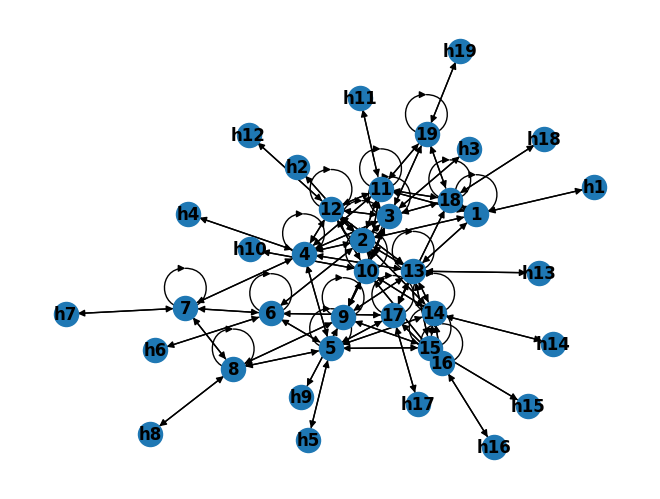

In [7]:
import matplotlib.pyplot as plt
_, graph = get_full_topo_graph()
# json to networkx object
# plot graph
nx.draw(graph, with_labels=True, font_weight='bold')
plt.show()

In [16]:
import networkx as nx

nx.has_path(graph, 
            'h1', 'h3')

True

In [1]:
import requests as rq
import json
data = {
  "route": [
    {
      "src_host": 2,
      "dst_host": 9
    },
    {
      "src_host": 1,
      "dst_host": 3
    },
    {
      "src_host": 2,
      "dst_host": 3
    },
    {
      "src_host": 1,
      "dst_host": 4
    },
    {
      "src_host": 2,
      "dst_host": 4
    },
    {
      "src_host": 3,
      "dst_host": 9
    },
    {
      "src_host": 1,
      "dst_host": 9
    }
  ]
}

rq.post('http://0.0.0.0:8001/routing', data=json.dumps(data)).json()

[{'status': 200,
  'flowrule': {'dpid': 2,
   'cookie': 1,
   'cookie_mask': 1,
   'table_id': 0,
   'idle_timeout': 3000,
   'hard_timeout': 3000,
   'priority': 1,
   'flags': 1,
   'match': {'in_port': 1,
    'dl_src': '00:00:00:00:00:02',
    'dl_dst': '00:00:00:00:00:09'},
   'actions': [{'type': 'OUTPUT', 'port': 5}]}},
 {'status': 200,
  'flowrule': {'dpid': 2,
   'cookie': 1,
   'cookie_mask': 1,
   'table_id': 0,
   'idle_timeout': 3000,
   'hard_timeout': 3000,
   'priority': 1,
   'flags': 1,
   'match': {'in_port': 5,
    'dl_src': '00:00:00:00:00:09',
    'dl_dst': '00:00:00:00:00:02'},
   'actions': [{'type': 'OUTPUT', 'port': 1}]}},
 {'status': 200,
  'flowrule': {'dpid': 9,
   'cookie': 1,
   'cookie_mask': 1,
   'table_id': 0,
   'idle_timeout': 3000,
   'hard_timeout': 3000,
   'priority': 1,
   'flags': 1,
   'match': {'in_port': 5,
    'dl_src': '00:00:00:00:00:02',
    'dl_dst': '00:00:00:00:00:09'},
   'actions': [{'type': 'OUTPUT', 'port': 1}]}},
 {'status': 200,

In [ ]:
{ 'route:': 
    {
            'src_host': 1,
            'dst_host': 4,
            'path_dpid': [1, 2, 3, 4],
    },
    {
            'src_host': 6,
            'dst_host': 2,
            'path_dpid': [6, 5, 4, 3, 2]
    },
    ...
}

In [11]:
from helper.utils import mac_to_int

hosts = rq.get('http://0.0.0.0:8080/hosts').json()['hosts']
max_display_mac =100
if max_display_mac > 0: 
    hosts = {'hosts': [host for host in hosts if mac_to_int(host['mac']) < 100]}
    
hosts

{'hosts': [{'mac': '00:00:00:00:00:0d',
   'ipv4': [],
   'ipv6': ['fe80::200:ff:fe00:d'],
   'port': {'dpid': '000000000000000d',
    'port_no': '00000001',
    'hw_addr': '16:98:85:7e:c1:55',
    'name': 's13-eth1'}},
  {'mac': '00:00:00:00:00:01',
   'ipv4': ['10.0.0.1'],
   'ipv6': ['fe80::200:ff:fe00:1'],
   'port': {'dpid': '0000000000000001',
    'port_no': '00000001',
    'hw_addr': 'fe:59:d7:ee:c1:f7',
    'name': 's1-eth1'}},
  {'mac': '00:00:00:00:00:12',
   'ipv4': [],
   'ipv6': ['fe80::200:ff:fe00:12'],
   'port': {'dpid': '0000000000000012',
    'port_no': '00000001',
    'hw_addr': '9a:e8:c2:f5:ec:5f',
    'name': 's18-eth1'}},
  {'mac': '00:00:00:00:00:04',
   'ipv4': [],
   'ipv6': ['fe80::200:ff:fe00:4'],
   'port': {'dpid': '0000000000000004',
    'port_no': '00000001',
    'hw_addr': 'a6:31:a6:80:0d:8c',
    'name': 's4-eth1'}},
  {'mac': '00:00:00:00:00:0b',
   'ipv4': [],
   'ipv6': ['fe80::200:ff:fe00:b'],
   'port': {'dpid': '000000000000000b',
    'port_no': '

In [ ]:
new_hosts = {'hosts': [host for host in get_host()['hosts'] if mac_to_int(host['mac']) < 100]}

In [4]:
path = [1,2,3]
path[1:-1]

[2]

In [4]:
_, graph = get_full_topo_graph()
nx.has_path(graph, 'h1', 'h6')

True

In [2]:
def get_variable_value(func, variable):
    # Get the local variables of the function
    local_vars = func.__code__.co_varnames

    # Check if the variable exists in the local variables
    if variable in local_vars:
        return func()
    else:
        return None

def my_function():
    variable = "Hello, world!"
    return variable

result = get_variable_value(my_function, "variable")
print(result)  # Output: Hello, world!

Hello, world!


In [45]:
def get_link_quality():
    '''
        Get from data from /link_quality
        currently working as a workaround for link utilization
    '''

    link_quality_controller = rq.get('http://0.0.0.0:8080/link_quality').json()
    link_quality_mininet = rq.get('http://0.0.0.0:8000/link_quality').json()

    lqc_hmap = {}
    lqm_hmap = {}

    for d in link_quality_controller:
        key = (d['src.dpid'], d['dst.dpid'])
        lqc_hmap[key] = d

    for d in link_quality_mininet:
        key = (d['src.dpid'], d['dst.dpid'])
        lqm_hmap[key] = d

    link_quality = []
    for key, lqc_value in lqc_hmap.items():
        lqm_value = lqm_hmap.get(key)
        if lqm_value == None: continue  
        link_quality.append({
            'src.dpid': key[0],
            'dst.dpid': key[1],
            'packet_loss': lqm_value.get('packet_loss', None),
            'bandwidth': lqm_value.get('bandwidth', None),
            'delay': lqc_value.get('delay', None),
            'link_utilization': lqc_value.get('link_usage') / lqm_value.get('bandwidth') * 100,
        })
        
    return link_quality
get_link_quality()

[{'src.dpid': 9,
  'dst.dpid': 6,
  'packet_loss': 1,
  'bandwidth': 98,
  'delay': 34.336209297180176,
  'link_utilization': 0.0006174812477473486},
 {'src.dpid': 20,
  'dst.dpid': 19,
  'packet_loss': 1,
  'bandwidth': 89,
  'delay': 10.496735572814941,
  'link_utilization': 0.0003594307515472373},
 {'src.dpid': 7,
  'dst.dpid': 5,
  'packet_loss': 0,
  'bandwidth': 79,
  'delay': 37.79757022857666,
  'link_utilization': 0.0004386723412870808},
 {'src.dpid': 7,
  'dst.dpid': 1,
  'packet_loss': 0,
  'bandwidth': 74,
  'delay': 48.13027381896973,
  'link_utilization': 0.0006016012680457855},
 {'src.dpid': 6,
  'dst.dpid': 9,
  'packet_loss': 1,
  'bandwidth': 98,
  'delay': 34.336209297180176,
  'link_utilization': 0.0006174812477473486},
 {'src.dpid': 6,
  'dst.dpid': 5,
  'packet_loss': 1,
  'bandwidth': 73,
  'delay': 31.61752223968506,
  'link_utilization': 0.0004382100943521103},
 {'src.dpid': 8,
  'dst.dpid': 2,
  'packet_loss': 0,
  'bandwidth': 70,
  'delay': 23.63884449005127

In [33]:
link_quality_mininet

[{'src.dpid': 1, 'dst.dpid': 4, 'loss': 1, 'delay': 32, 'bandwidth': 59},
 {'src.dpid': 4, 'dst.dpid': 1, 'loss': 1, 'delay': 32, 'bandwidth': 59},
 {'src.dpid': 1, 'dst.dpid': 12, 'loss': 0, 'delay': 33, 'bandwidth': 82},
 {'src.dpid': 12, 'dst.dpid': 1, 'loss': 0, 'delay': 33, 'bandwidth': 82},
 {'src.dpid': 1, 'dst.dpid': 7, 'loss': 0, 'delay': 22, 'bandwidth': 94},
 {'src.dpid': 7, 'dst.dpid': 1, 'loss': 0, 'delay': 22, 'bandwidth': 94},
 {'src.dpid': 2, 'dst.dpid': 12, 'loss': 3, 'delay': 24, 'bandwidth': 59},
 {'src.dpid': 12, 'dst.dpid': 2, 'loss': 3, 'delay': 24, 'bandwidth': 59},
 {'src.dpid': 2, 'dst.dpid': 8, 'loss': 2, 'delay': 10, 'bandwidth': 97},
 {'src.dpid': 8, 'dst.dpid': 2, 'loss': 2, 'delay': 10, 'bandwidth': 97},
 {'src.dpid': 3, 'dst.dpid': 4, 'loss': 4, 'delay': 43, 'bandwidth': 68},
 {'src.dpid': 4, 'dst.dpid': 3, 'loss': 4, 'delay': 43, 'bandwidth': 68},
 {'src.dpid': 3, 'dst.dpid': 12, 'loss': 3, 'delay': 48, 'bandwidth': 86},
 {'src.dpid': 12, 'dst.dpid': 3, 

In [4]:
import os
os.getenv('PYTHONPATH')